In [1]:
import numpy as np
import pandas as pd
import os.path #for saving
import ipywidgets as widgets

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle 
from mpl_toolkits.mplot3d import axes3d  
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection 
from IPython.display import display

%matplotlib nbagg
# Magic for plots in aseparate window. Alternatives: 'notebook' and 'inline' (HTML)

In [2]:
# Dropdown menus
technique = ["Optical", "SEM", "Laser"]

#optical
modalities_OM = ["reflected", "transmitted"]
angles_OM = np.arange(0, 181, 15)

#SEM
modalities_SEM = ["EDX", "BSE", "SE"]
map_EDX = ["QuantMap", "TruMap", "PhaseMap"]
nElements = 28

#Laser
modes_Laser = ["TOF", "Quadrupole"]

#Properties
binningFactor = [1, 2, 4, 8, 16, 32, 64]
bitDepth = [8, 16, 24, 32, 64]
nIsotopes = 0 #not used

# Initial input
sample = "MBS-4"

# Saving directory
directory = './results/'
if not os.path.isdir(directory):
    os.mkdir(directory)

In [3]:
# Images metadata

#Option 1: Manual user input into notebook (default)
#Option 2: Manual user input to GUI interface..
#Option 3: Information should be loaded automatically from diverse metadata files (OME-TIFF.xml)

#Color legend
layerColors = ['yellow', 'red', 'blue', 'cyan', 'grey', 'magenta']

experiments = []
#OM RL PPL
exp_type = technique[0]+ " " +modalities_OM[0]+ " " + str(angles_OM[0])
exp_bitDepth = bitDepth[0]
exp_binningFactor = binningFactor[0]
exp_channels = 3*len(angles_OM[0:1])
exp_spatialResolution = 0.58
exp_width = 73271
exp_height = 44296
exp_tileWidth = 4908
exp_tileHeight = 3264
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#BSE
exp_type = technique[1]+ " " +modalities_SEM[1]
exp_bitDepth = bitDepth[0]
exp_binningFactor = binningFactor[0]
exp_channels = 1
exp_spatialResolution = 2.6
exp_width = 15943
exp_height = 9265
exp_tileWidth = 768
exp_tileHeight = 768
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#TruMap
exp_type = technique[1]+ " " +modalities_SEM[0]+ " " +map_EDX[1]
exp_bitDepth = bitDepth[1]
exp_binningFactor = binningFactor[0]
exp_channels = nElements
exp_spatialResolution = 3.91
exp_width = 9267
exp_height = 5913
exp_tileWidth = 512
exp_tileHeight = 384
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#PhaseMap
exp_type = technique[1]+ " " +modalities_SEM[0]+ " " +map_EDX[2]
exp_bitDepth = bitDepth[0]
exp_binningFactor = binningFactor[0]
exp_channels = 1
exp_angles = angles_OM[0]
exp_spatialResolution = 3.91
exp_width = 9267
exp_height = 5913
exp_tileWidth = 512
exp_tileHeight = 384
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#QuantMap
exp_type = technique[1]+ " " +modalities_SEM[0]+ " " +map_EDX[0]
exp_bitDepth = bitDepth[3]
exp_binningFactor = binningFactor[1]
exp_channels = nElements
exp_spatialResolution = 3.91
exp_width = 9267
exp_height = 5913
exp_tileWidth = 512
exp_tileHeight = 384
exp_overlap = 15
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

#LA-ICP-Q-MS mapping
exp_type = technique[2]+ " " +modes_Laser[1]
exp_bitDepth = bitDepth[3]
exp_binningFactor = binningFactor[0]
exp_channels = nIsotopes
exp_spatialResolution = 9
exp_width = 100
exp_height = 100
exp_tileWidth = np.nan
exp_tileHeight = np.nan
exp_overlap = np.nan
layer = [exp_type, exp_bitDepth, exp_channels, exp_spatialResolution,
         exp_binningFactor, exp_width, exp_height, exp_tileWidth, 
         exp_tileHeight, exp_overlap]
experiments.append(layer)

dfPyramid = pd.DataFrame(experiments, 
                         columns=['Layer', 'Bit depth', 'Num. channels', 'Spatial resolution', 
                                  'Binning factor', 'Width', 'Height', 
                                  'Tile width', 'Tile height', 'Overlap'])

dfPyramid['Columns'] = np.ceil(100*dfPyramid['Width']/(dfPyramid['Tile width']*(100-dfPyramid['Overlap'])))
dfPyramid['Rows'] = np.ceil(100*dfPyramid['Height']/(dfPyramid['Tile height']*(100-dfPyramid['Overlap'])))

# Saving input to csv
filename = sample + '_userInput' + '.csv'
file_path = os.path.join(directory, filename)
dfPyramid.to_csv (file_path, index = False, header=True)

In [ ]:
# Loading previous dataframe input
filename = sample + '_userInput' + '.csv'
file_path = os.path.join(directory, filename)
dfPyramid = pd.read_csv(file_path) 

dfPyramid

In [4]:
# Finding reference layer (default value)
binnedResolution = dfPyramid['Spatial resolution']*dfPyramid['Binning factor']
spatialRes_min = min(binnedResolution) 
index_min = int(np.where(binnedResolution == spatialRes_min)[0]) #int() for indexing


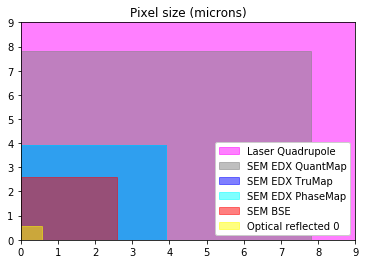

In [5]:
# Comparing pixel sizes
reverseIndex = sorted(range(len(binnedResolution)), 
                      key=lambda k: binnedResolution[k], reverse=True)
binnedRes_sort = binnedResolution.loc[reverseIndex].reset_index(drop=True)
colors = [layerColors[i] for i in reverseIndex]

fig1 = plt.figure() 
ax = fig1.add_subplot(111) 

rect_temp = []
for i in range(0, len(colors)):
    width = binnedRes_sort[i]
    height = binnedRes_sort[i]
    temp = Rectangle((0, 0), width, height, color = colors[i], alpha = 0.5) 
    rect_temp.append(temp)
    ax.add_patch(temp) 

layer_names = dfPyramid.loc[reverseIndex, 'Layer']
plt.xlim([0, max(binnedRes_sort)]) 
plt.ylim([0, max(binnedRes_sort)]) 
plt.legend(rect_temp, layer_names, loc='lower right', framealpha = 1)
plt.title('Pixel size (microns)')

#Saving image
filename = sample + '_pixelComparison' + '.png'
file_path = os.path.join(directory, filename)
plt.savefig(file_path)

In [6]:
# General pyramid settings

#Following pyramidal OME-TIFF (X×Y×Z×C×T)
timeSeries = 1 
zSeries = 1 
compression = "JPEG" #for calculating File size (see below)
compression_quality = 90

#Base of pyramid Dim (default layer)
w = int(dfPyramid.loc[index_min]['Width'])
h = int(dfPyramid.loc[index_min]['Height']) #int() for avoiding df series element

# refIndex = 0 #Alternative: manual selection
# w = dfPyramid.loc[refIndex]['Width']
# h = dfPyramid.loc[refIndex]['Height']

#Apex
zoom = (w + h)/2 

#Number of levels (default)
nLevels = 9 
blockWidth = 512 #command line input in LIBVIPS 
blockHeight = 512

In [8]:
#Interactive plot

def update_plot(w, h, zoom, blockWidth, blockHeight):   
    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.clear()
    
    # Vertices of pyramid
    v = np.array([[-w/2, -h/2, 0], [w/2, -h/2, 0], [w/2, h/2, 0],  [-w/2, h/2, 0], 
                  [0, 0, zoom]])
    X = v[:, 0] 
    Y = v[:, 1]
    Z = v[:, 2] #for 3D scatter plot

    # Block 
    # At bottom left corner
    # bVx = min(v[:, 0])
    # bVy = min(v[:, 1])
    # bVz = 0
    # blockVerts = np.array([[bVx, bVy, 0], [bVx+blockWidth, bVy, 0],
    #                       [bVx + blockWidth, bVy + blockHeight, 0], [bVx, bVy + blockHeight, 0]])

    #At nadir
    blockVerts = np.array([[-blockWidth/2, -blockHeight/2, 0], [blockWidth/2, -blockHeight/2, 0],
                          [blockWidth/2, blockHeight/2, 0], [-blockWidth/2, blockHeight/2, 0]])

    
    #Estimating number of pyramid levels
    testW = w
    i = 1 #when 1 block contains the whole slide
    while testW > blockWidth:
        i += 1 
        testW = testW/2

    testH = h
    j = 1
    while testH > blockHeight:
        j += 1 
        testH = testH/2

    nLevels = max(i, j) #block clamped around both Dim(X and Y)
    
    #Z coordinates of levels (reference pyramid)
    zDist = []
    for i in range(0, nLevels):
        temp = zoom*(1-2**-i)
        zDist.append(temp)

    newVerts = []
    for i in range(0, nLevels):    
        vertex = []
        for j in range(0, 4):
            z = zDist[i]
            [x0, y0, z0] = v[j]
            [x1, y1, z1] = v[4] #apex
            t = (z - z0)/(z1 - z0)
            x = x0 + (x1-x0)*t
            y = y0 + (y1-y0)*t
            temp1 = [x, y, z]
            vertex.append(temp1)

        test = np.array(vertex)
        newVerts.append(test)

    # Estimating Z coordinate of layer planes: for adding to pyramid plot
    layerZ = zoom*(1-binnedResolution[index_min]/binnedResolution)
    #layerResolution = ref_spResolution*2^n
    #layerZ = zoom*(1-1/2^n)
    #layerZ = zoom*(1-ref_spResolution/levelResolution)

    layerVerts = [] #rest of layers
    for i in range(0, len(layerZ)):
        vertex = []
        for j in range(0, 4):
            z = layerZ[i]
            [x0, y0, z0] = v[j]
            [x1, y1, z1] = v[4] #apex
            t = (z - z0)/(z1 - z0)
            x = x0 + (x1-x0)*t
            y = y0 + (y1-y0)*t
            temp1 = [x, y, z]
            vertex.append(temp1)

        test = np.array(vertex)
        layerVerts.append(test)
    
    # Vertex
    ax.scatter3D(X, Y, Z)

    # Sides
    uVerts = [[v[0],v[1],v[4]], [v[0],v[3],v[4]], [v[2],v[1],v[4]], [v[2],v[3],v[4]], 
             [v[0],v[1],v[2],v[3]]]
    ax.add_collection3d(Poly3DCollection(uVerts, alpha=0, facecolor = 'blue', 
                                         linewidths=.5, edgecolors='k'))

    # Levels: reference 
    for k in range(0, nLevels):
        uPyramid = [[newVerts[k][0], newVerts[k][1], newVerts[k][2], newVerts[k][3]]]
        ax.add_collection3d(Poly3DCollection(uPyramid, alpha=0.2, facecolor = 'peachpuff',
                                             linewidths=.5, edgecolors='k'))

    # Pyramidal block: reference
    uBlock = [[blockVerts[0], blockVerts[1], blockVerts[2], blockVerts[3]]]
    ax.add_collection3d(Poly3DCollection(uBlock, alpha=0.5, facecolor = 'k',
                                         linewidths=.5, edgecolors='k'))

    # Levels: rest of layers
    for m in range(0, len(layerZ)):
        if i == index_min:
            continue    
        uLayers = [[layerVerts[m][0], layerVerts[m][1], layerVerts[m][2], layerVerts[m][3]]]
        ax.add_collection3d(Poly3DCollection(uLayers, alpha=0.5, facecolor = layerColors[m],
                                             linewidths=.5, edgecolors='k'))

    # Layout 3D plot
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Zoom')
    ax.set_title('Pyramidal calculator (pixels)')

    #clamping pyramid
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    fig.tight_layout() #reduces margins

    #Saving image
    filename = sample + '_referencePyramid' + '.png'
    file_path = os.path.join(directory, filename)
    plt.savefig(file_path)
    
#Linking sliders with plot
w_interact = widgets.IntSlider(min= 200, max= 10**5, value= w, description= 'Base width')
h_interact = widgets.IntSlider(min= 200, max= 10**5, value= h, description= 'Base height')
zoom_interact = widgets.FloatSlider(min= 200, max= 10**5, value= zoom, description= 'Vertical zoom')
nLevels_interact = widgets.IntSlider(min= 1, max= 20, value= nLevels, description= 'Number of levels')
blockWidth_interact = widgets.IntSlider(min= 256, max= 10**4, value= blockWidth, description= 'Block width')
blockHeight_interact = widgets.IntSlider(min= 256, max= 10**4, value= blockHeight, description= 'Block height')

widgets.interactive(update_plot, w= w_interact, h= h_interact, zoom= zoom_interact, 
                    blockWidth= blockWidth_interact, blockHeight= blockHeight_interact)



interactive(children=(IntSlider(value=73271, description='Base width', max=100000, min=200), IntSlider(value=4…

In [ ]:
# Calculating pyramidal image size

base = pd.Series([2]*nLevels)
exponent = pd.Series(np.arange(0, nLevels))
pyramid_scale = base.pow(exponent)

bytes = 0
for i in range(0, nLevels):
    temp = (dfPyramid.iloc[index_min][2] * zSeries * timeSeries * w * 
            h * dfPyramid.iloc[index_min][1]) / ((pyramid_scale[i]**2) * 8)
    bytes = bytes + temp

singleImageSize = bytes/(1024**3) #gigabytes
depthRatio = singleImageSize/(dfPyramid.iloc[index_min][2] * dfPyramid.iloc[index_min][1])

dfPyramid['Image size (GB)'] = round((depthRatio * dfPyramid['Bit depth'] * 
                                dfPyramid['Num. channels']), 1)

total_mix = round(sum(dfPyramid['Image size (GB)']), 1)
total_float32 = round(sum(dfPyramid['Num. channels']) * 
                      depthRatio * dfPyramid.loc[4, 'Bit depth'], 1)

total_mix, total_float32 #Gigabytes

# Calculating file size
#depends on compression..

In [ ]:
# Comparing tile sizes 
tileWidthSize = dfPyramid['Tile width']*dfPyramid['Spatial resolution']
tileHeightSize = dfPyramid['Tile height']*dfPyramid['Spatial resolution']
tileArea = tileWidthSize*tileHeightSize

reverseIndex = sorted(range(len(tileArea)), 
                      key=lambda k: tileArea[k], reverse=True)

tileWidthSize_sort = tileWidthSize.loc[reverseIndex].reset_index(drop=True)
tileHeightSize_sort = tileHeightSize.loc[reverseIndex].reset_index(drop=True)
colors = [layerColors[i] for i in reverseIndex]

fig2 = plt.figure() 
ax = fig2.add_subplot(111) 

rect_temp = []
for i in range(0, len(colors)):
    width = tileWidthSize_sort[i]
    height = tileHeightSize_sort[i]
    temp = Rectangle((0, 0), width, height, color = colors[i], alpha = 0.5) 
    rect_temp.append(temp)
    ax.add_patch(temp) 

#adding pyramid block
block_temp = Rectangle((0, 0), blockWidth, blockHeight, color = 'blue', alpha = 0.5)
rect_temp.append(block_temp)
ax.add_patch(block_temp)
layer_names = dfPyramid.loc[reverseIndex, 'Layer']
all_names = layer_names.append(pd.Series('Pyramid block'))

plt.xlim([0, max(tileWidthSize_sort)]) 
plt.ylim([0, max(tileHeightSize_sort)]) 
plt.legend(rect_temp, all_names, loc='lower right', framealpha = 1)
plt.title('Tile size (microns)')

#Saving image
filename = sample + '_tileComparison' + '.png'
file_path = os.path.join(directory, filename)
plt.savefig(file_path)

# Note: slide size can be compared in MatLab registration script. 
# The alternative would be importing transformation spatial reference into this notebook and plotting